# C6.1 Fiber coupling
Jeg Vet

huangzw29@mail2.sysu.edu.cn

2022-04-04

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

In [1]:
def Cal(parlist, dflist, udic, formula, result_path = "Uncertainty_report.txt"):
    '''
    Given a formula and measurements of required parameters, 
    calculate the result and uncertainty.

    parlist: A list of names of required parameters 
    dflist: A list of dataframes containing the original measurements of required parameters. 
            Column names must include all elements containing in the parlist.
    udic: A dictionary whose keys are the names of parameters containing in the parlist,
          and values are corresponding type B uncertainties depending on the minimum scale intervals of the measuring instruments.
          A typical calculation formula is "minimum scale interval/(3)**(1/2)"
    formula: Physical formula. 
             Use capital letters 'A', 'B', 'C', etc. to represent parameters in the same order as they are provided in the parlist. 
                For example, if the parlist is ["m", "t", "d"], the original formula is "(d+sp.log(m))/t", 
                then the formula should be "(C+sp.log(A))/B"
             Except for these, the formula SHOULD NOT contain any other variable whose name contains capital letters.
             Use sympy function instad of numpy function in the formula.
    result_path: Path of the output file. Default: "Uncertainty_report.txt"
    '''
    # Import neccessary lib
    import numpy as np 
    import pandas as pd
    import sympy as sp
    # Initialization
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    pardic = {}
    par_var_symbol_list = []
    subs = {}    
    S_type_A = 0
    S_type_B = 0
    S_exp = 0
    # Concat measurements and calculate mean and std for every parameter
    df = pd.concat(dflist)
    df_par = pd.DataFrame(df.describe().loc[['mean', 'std']][parlist])
    # Assign
    for i in np.arange(0, len(parlist)):
        # mean    
        par_var = alphabet[i] # assign a variable name for every parameter
        pardic[parlist[i]] = par_var # store the name of parameters and their corresponding variable names in a dic
        globals()[par_var] = tuple(df_par.loc['mean'])[i] # assign mean values
        # std
        par_var_std = par_var + '_std' 
        globals()[par_var_std] = tuple(df_par.loc['std'])[i] # assign std values
        # symbol
        par_var_symbol = par_var.upper()
        globals()[par_var_symbol] = sp.symbols(par_var_symbol) # define symbols
        par_var_symbol_list.append(par_var_symbol)
        # subs
        subs[par_var_symbol] = eval(par_var) # value of every symbol
    
    # Partial derivatives
    res = eval(formula) # formula
    for i in par_var_symbol_list:
        globals()["res_" + i] = sp.diff(res, i).evalf(subs = subs)

    # Uncertainty
    for i in np.arange(0, len(parlist)):
        par_var = pardic[parlist[i]]
        S_type_A += (eval(par_var+'_std')*eval('res_'+ par_var.upper()))**2
    S_type_A = (S_type_A)**(1/2)
    for i in np.arange(0, len(parlist)):
        par_var = pardic[parlist[i]]
        S_type_B += (udic[parlist[i]]*eval('res_'+ par_var.upper()))**2
    S_type_B = (S_type_B)**(1/2)
    S_exp = ((S_type_A)**2 + (S_type_B)**2)**(1/2)
    
    # Result
    res = eval(formula.lower())

    # Output report
    print('Result: $'+str(res)+' \pm '+str(S_exp)+'$')
    with open(result_path, 'w') as f:
        f.write("# Output of the uncertainty calculation\n\n")
        f.write("-----------------------------------------\n\n")
        f.write("## Input: \n\n")
        f.write("Original measurements:\n")
        for i in dflist:
            f.write("Dataframe: \n")
            f.write(i.to_string())
            f.write('\n')
        f.write('\n')   
        f.write("Parameters: ")
        f.write(str(parlist))
        f.write('\n')
        f.write("U: ")
        f.write(str(udic))
        f.write('\n')
        f.write("Formula: ")
        f.write(formula)
        f.write('\n\n')
        f.write("-----------------------------------------\n\n")
        f.write("## Output: \n\n")
        f.write("Basic statistics of your dataframes: \n")
        for i in dflist:
            f.write("Dataframe summary: \n")
            f.write(pd.DataFrame(i.describe()).to_string())
            f.write('\n')
        f.write('\n')
        f.write("Mean and std of your parameters: \n")
        f.write(df_par.to_string())
        f.write('\n\n')
        f.write("Result: ")
        f.write(str(res))
        f.write('\n\n')
        f.write("Uncertainty of the result: \n")
        f.write("Type A uncertainty: "+ str(S_type_A) + "\n")
        f.write("Type B uncertainty: "+ str(S_type_B) + "\n")
        f.write("Expanded uncertainty: "+ str(S_exp) + "\n")
        f.write('\n')
        f.write('Final Result: $'+str(res)+' \pm '+str(S_exp)+'$\n')
        f.close


In [7]:
df1 = pd.read_csv("Input/input-power.csv", sep=",")
df2 = pd.read_csv("Input/output-power.csv", sep=",")
df3 = pd.read_csv("Input/numerical-aperture.csv", sep=",")

## Coupling

### Transmission loss(dB)
https://zhuanlan.zhihu.com/p/345347516

In [13]:
fiber = ["fiber_A", "fiber_B", "fiber_C"]
for i in fiber:
    dflist = [df1, df2[df2.fiber == i]]
    formula = "-10*sp.log(A/B)"
    for idx in ["dir", "focus"]:    
        parlist = [idx, "laser"]
        udic = {"dir":1e-8/(3**(1/2)), "laser":1e-5/(3**(1/2)), "focus":1e-5/(3**(1/2))}  
        result_path = "Output/Coupling//"+i+"-"+idx+"-Transmission loss.txt"  
        Cal(parlist, dflist, udic, formula, result_path)

Result: $58.0567678233754 \pm 0.141949706136649$
Result: $3.04018491771474 \pm 0.204431005793697$
Result: $93.9998030957782 \pm 0.386349775707256$
Result: $3.37514446199656 \pm 0.172454268188975$
Result: $103.762728247437 \pm 0.823600025131003$
Result: $8.07810088880085 \pm 0.283077284212958$


### Coupling efficiency

In [16]:
fiber = ["fiber_A", "fiber_B", "fiber_C"]
for i in fiber:
    dflist = [df1, df2[df2.fiber == i]]
    formula = "100*A/B"
    for idx in ["dir", "focus"]:    
        parlist = [idx, "laser"]
        udic = {"dir":1e-8/(3**(1/2)), "laser":1e-5/(3**(1/2)), "focus":1e-5/(3**(1/2))}  
        result_path = "Output/Coupling/"+i+"-"+idx+"-Coupling efficiency.txt"  
        Cal(parlist, dflist, udic, formula, result_path)

Result: $0.30104166666666676 \pm 0.00427327761182203$
Result: $73.78472222222224 \pm 1.50838849760975$
Result: $0.008272569444444445 \pm 0.000319610534938381$
Result: $71.35416666666669 \pm 1.23053305947341$
Result: $0.0031163194444444454 \pm 0.000256660077276068$
Result: $44.58333333333334 \pm 1.26205289211610$


## Numerical aperture

In [23]:
def fitplot(df, par, xlab="x", ylab="y", deg=1, result_path="Output/fit.png"):
    '''
    df: dataframe
    par: {"x": "", "y": ""}
    deg: fit degree
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    # fit
    func = np.polyfit(df[par["x"]], df[par["y"]], deg=deg)
    x_dense = np.linspace(df[par["x"]].min(), df[par["x"]].max(), 50)
    reg = np.polyval(func, x_dense)
    r = np.corrcoef(df[par["x"]], df[par["y"]])[0,1]
    coef_1, coef_2 = tuple(func)
    plt.figure(figsize= (9, 6))
    plt.scatter(df[par["x"]], df[par["y"]], color='#d46c75')
    plt.plot(x_dense, reg, color='lightseagreen', 
                            label='Fit. \ny = {:.4f}x + {:.4f}\nr = {:.8f}'
                            .format(coef_1, coef_2, r))    
    sns.regplot(x=df[par["x"]], y=df[par["y"]], color = 'lightseagreen', scatter = False)                          
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300)   

In [1]:
def fitplot_func(df, par, function, xlab="x", ylab="y", result_path = "Output/fit.png"):
    '''
    df: dataframe
    par: {"x": "", "y": ""}
    function: 
        def my_func(A, x):
        return A*x**2-x
    '''
    from scipy.optimize import curve_fit
    from textwrap import fill
    x = df[par["x"]]
    y = df[par["y"]]
    popt, pcov = curve_fit(function, x, y)
    x_dense = np.linspace(x.min(), x.max(), 100)
    reg = function(x_dense, *popt)
    plt.figure(figsize= (10, 6))
    plt.scatter(df[par["x"]], df[par["y"]], color='lightcoral', label='Observation')
    plt.plot(x_dense, reg, color='lightseagreen', 
                            label='Fit. \n Coefficients: {}'.format(popt))
    plt.legend()                        
    # plt.legend(bbox_to_anchor=(0.4, 0.6, 0.5, 0.3))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(i+': NA = {:.3f}'.format( (4*(popt[0])**2+1)**(-1/2) ), y=-0.17)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300)   
    print(pcov)
    print((4*(popt[0])**2+1)**(-1/2))
    print(popt[0])

[[0.00017346]]
0.27665856697351227
1.7367405094900812
[[0.00228185]]
0.1853844275830236
2.6503468692872723
[[0.00046796]]
0.18297997928366663
2.686404937609172


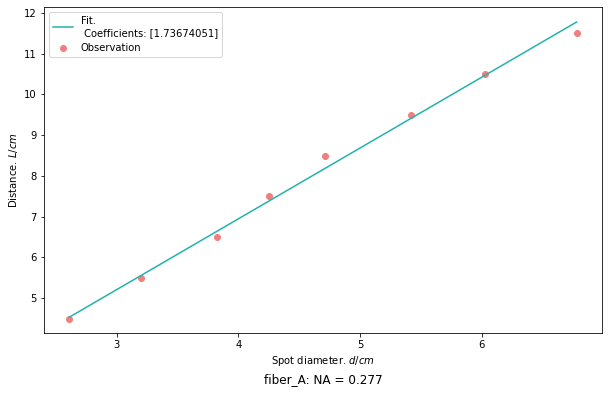

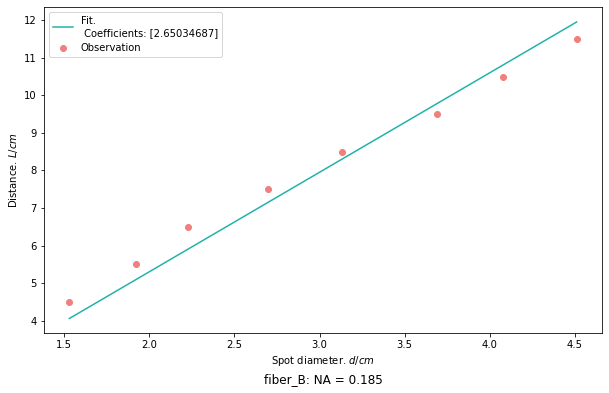

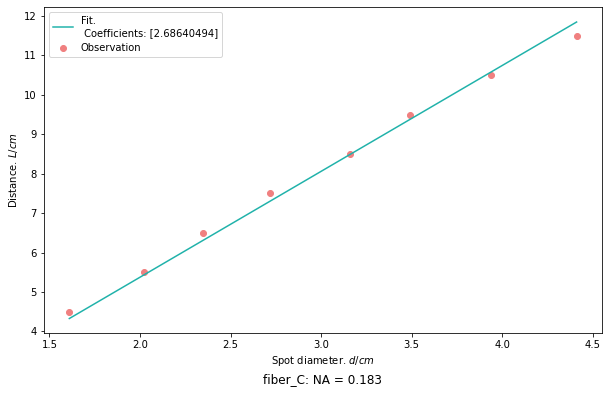

In [8]:
fiber = ["fiber_A", "fiber_B", "fiber_C"]
def my_func(x, A):
    return A*x

for i in fiber:
    df3[i+"-NA"] = (df3[i]/2) /( (df3["L"])**2 + (df3[i]/2)**2 )**(1/2)
    fitplot_func(df3, 
                par = {"x": i, "y": "L"}, 
                xlab ="Spot diameter. $d/cm$", ylab = "Distance. $L/cm$", 
                function = my_func,
                result_path = "Output/NA/NAfit-"+i+".png")